# Vizualizace a načtení dat
Data prezentované níže jsou exporty pouze ze čtečky (zatím bez fyzické aktivity se smart hodinek, která se sleduje od prosince. Od 9.1. jsem začal informace o sacharidech a inzulinu zapisovat do aplikace mySugr, co je pohodlnější než zapisovat tyto údaje do čtečky. Zároveň jsem začal evidovat informace o glykemicém indexu jídla (odhad toho jak rychle se snězené sacharidy uvolní do krve).

In [2]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
reader_data = "data/reader_data"
exports = [os.path.join(reader_data, export) for export in os.listdir(reader_data)]
exports.sort(reverse=False)
df = pd.read_csv(exports[0], sep="\t")
for export in exports[1:]:
    df = pd.concat([df, pd.read_csv(export, sep="\t")])
# Exports usually overlap
df.drop_duplicates(inplace=True)

In [4]:
print("Shape: ", df.shape)
print(df.columns)

Shape:  (35286, 19)
Index(['ID', 'Time', 'Record Type', 'Historic Glucose (mmol/L)',
       'Scan Glucose (mmol/L)', 'Non-numeric Rapid-Acting Insulin',
       'Rapid-Acting Insulin (units)', 'Non-numeric Food',
       'Carbohydrates (grams)', 'Non-numeric Long-Acting Insulin',
       'Long-Acting Insulin (units)', 'Notes', 'Strip Glucose (mmol/L)',
       'Ketone (mmol/L)', 'Meal Insulin (units)', 'Correction Insulin (units)',
       'User Change Insulin (units)', 'Previous Time', 'Updated Time'],
      dtype='object')


In [5]:
# Dropping column which aren't used
df.drop(['Non-numeric Food', 'Non-numeric Long-Acting Insulin', 'Non-numeric Rapid-Acting Insulin',
             'Notes', 'Strip Glucose (mmol/L)', 'Ketone (mmol/L)', 'User Change Insulin (units)', 'Correction Insulin (units)', 'ID'],
            axis=1, inplace=True)
df.info()

df['Time'] = pd.to_datetime(df['Time'], format="%Y/%m/%d %H:%M")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35286 entries, 0 to 10924
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Time                          35286 non-null  object 
 1   Record Type                   35286 non-null  int64  
 2   Historic Glucose (mmol/L)     29014 non-null  float64
 3   Scan Glucose (mmol/L)         5269 non-null   float64
 4   Rapid-Acting Insulin (units)  527 non-null    float64
 5   Carbohydrates (grams)         386 non-null    float64
 6   Long-Acting Insulin (units)   83 non-null     float64
 7   Meal Insulin (units)          0 non-null      float64
 8   Previous Time                 5 non-null      object 
 9   Updated Time                  5 non-null      object 
dtypes: float64(6), int64(1), object(3)
memory usage: 3.0+ MB


Ořezání na relevantní časový úsek který už obsahuje informace o inzulinu a sacharidech

In [6]:
df = df[df["Time"] <= "2022/01/09 00:00"]
df = df[df["Time"] >= "2021/12/01 00:00"]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6085 entries, 1370 to 10792
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Time                          6085 non-null   datetime64[ns]
 1   Record Type                   6085 non-null   int64         
 2   Historic Glucose (mmol/L)     3659 non-null   float64       
 3   Scan Glucose (mmol/L)         1822 non-null   float64       
 4   Rapid-Acting Insulin (units)  194 non-null    float64       
 5   Carbohydrates (grams)         368 non-null    float64       
 6   Long-Acting Insulin (units)   40 non-null     float64       
 7   Meal Insulin (units)          0 non-null      float64       
 8   Previous Time                 0 non-null      object        
 9   Updated Time                  0 non-null      object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 522.9+ KB


Sloupeček Historical Glucose a Scan Glucose se liší jen v tom, že Scan Glucose je hodnota glukózy v čase naskenován, zatímco Historical Glucose jsou záznamy, které si senzor ukládá průběžně. Tyto sloupce můžeme zkombinovat do jednoho "Glucose".

In [8]:
df["Glucose"] = df[["Historic Glucose (mmol/L)", "Scan Glucose (mmol/L)"]].apply(lambda x: x["Historic Glucose (mmol/L)"] if np.isnan(x["Scan Glucose (mmol/L)"]) else x["Scan Glucose (mmol/L)"], axis=1)

In [9]:
df.head()

,Time,Record Type,Historic Glucose (mmol/L),Scan Glucose (mmol/L),Rapid-Acting Insulin (units),Carbohydrates (grams),Long-Acting Insulin (units),Meal Insulin (units),Previous Time,Updated Time,Glucose
1370,2021-12-01 00:05:00,4,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN
1371,2021-12-01 00:05:00,1,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0
1372,2021-12-01 00:33:00,1,NaN,8.7,NaN,NaN,NaN,NaN,NaN,NaN,8.7
1373,2021-12-01 01:10:00,1,NaN,9.2,NaN,NaN,NaN,NaN,NaN,NaN,9.2
1374,2021-12-01 01:22:00,1,NaN,9.4,NaN,NaN,NaN,NaN,NaN,NaN,9.4


### Pohled na vývoj hladiny glukózy v čase, v cca. týdenních intervalech
- červená čára na hladině **10** mmol/L představuje hranici vysoké hladiny glukozy
- mezi oranžovou a fialovou je ideální (zdravá) hladina glukozy - **3.5 až 7.4** mmol/L
- pod fialovou čárou, **3.5 mmol/L** je nízká hladina

In [10]:
df.sort_values(by='Time', inplace=True)

In [11]:
duration = df["Time"].iloc[-1] - df["Time"].iloc[0]

# Divide to approximately weekly chunks of data
chunks = duration.days % 7
# We're dropping records for insulin and carbohydrates (we're only plotting glucose)
weekly_df = np.array_split(df.dropna(subset=["Glucose", "Time"]), chunks)

In [76]:
def plot_boundries(low=3.4, medium=7.4, high=10):
    plt.axhline(y = low, color = 'purple', linestyle = '-')
    plt.axhline(y = medium, color = 'orange', linestyle = '-')
    plt.axhline(y = high, color = 'r', linestyle = '-')

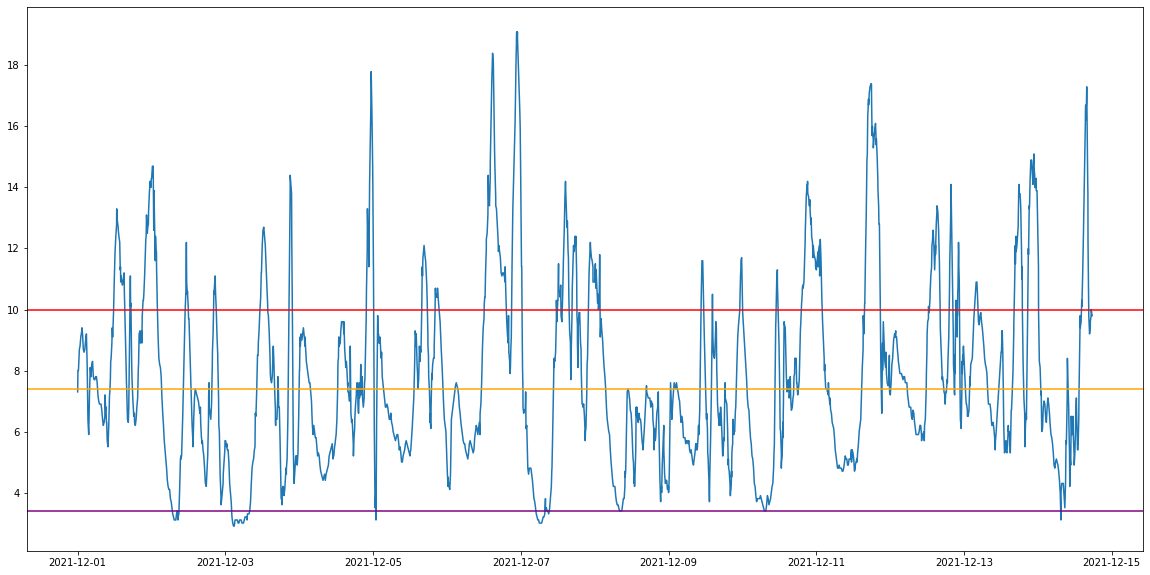

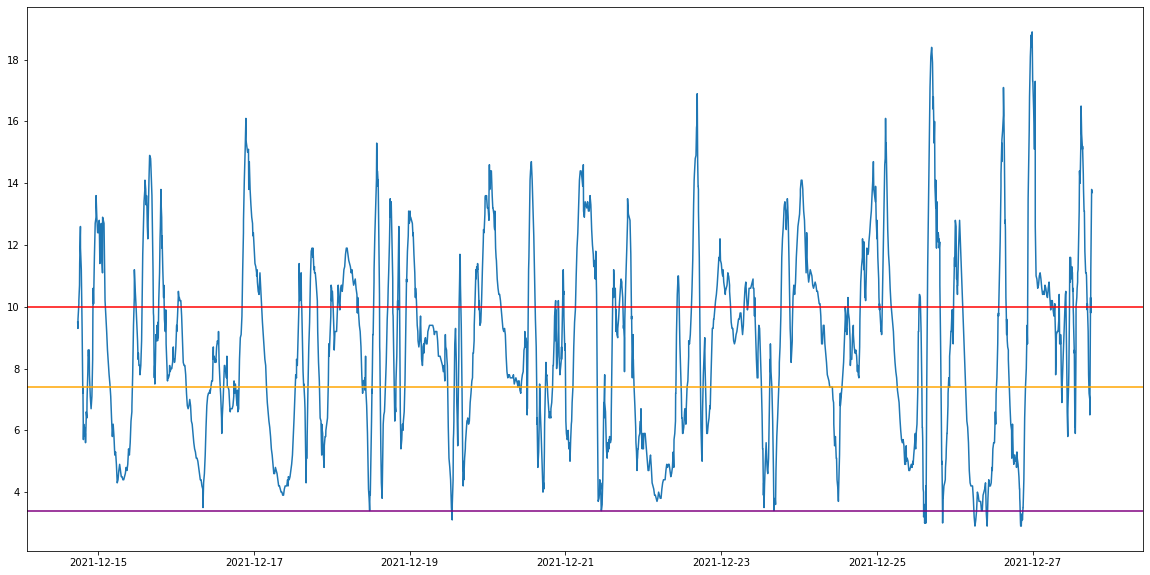

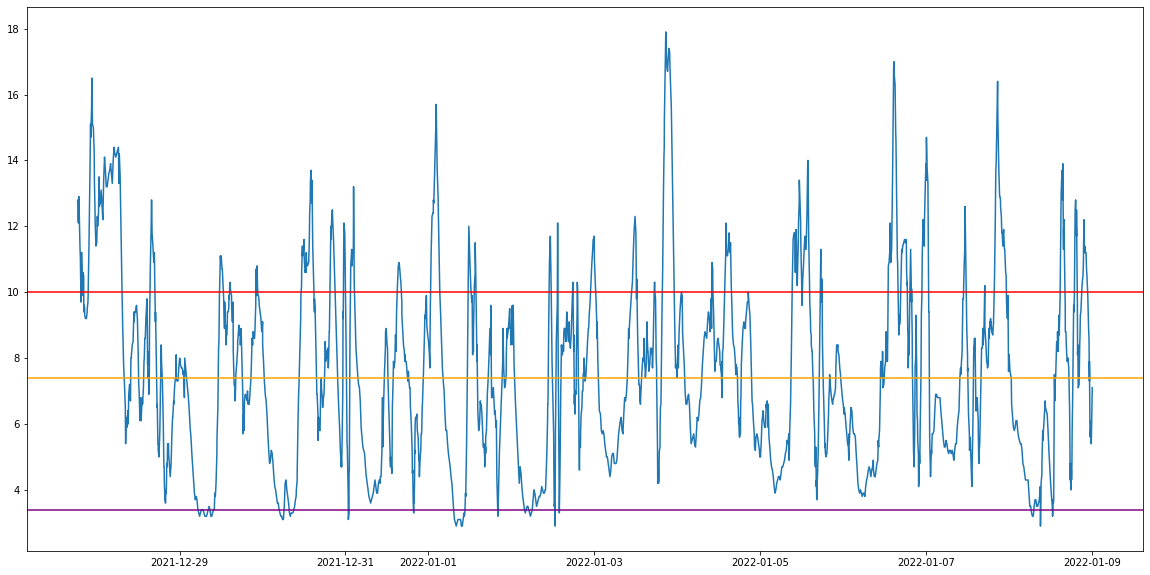

In [78]:
for chunk_df in weekly_df:
    plt.figure(figsize=(20, 10))
    plt.plot(chunk_df["Time"], chunk_df["Glucose"])

    plot_boundries()
    plt.show()

### Pohled na vývoj hladiny glukózy v jednotlivých dnech spolu s vykreslením časů a kvantit sacharidů a inzulinu

In [92]:
def get_daily_charts(df, start_day=2, duration_days=5):
    # Fix later (copy being done somewhere)
    pd.options.mode.chained_assignment = None

    daily_df_list = np.array_split(df, int(duration.days))
    # For each day do a plot
    for day_df in daily_df_list[start_day:start_day + duration_days]:
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot()

        glucose_data = day_df.dropna(subset=["Glucose", "Time"])
        ax.plot(glucose_data["Time"], glucose_data["Glucose"])

        plot_boundries()

        rapid_insulin = day_df.dropna(subset=["Rapid-Acting Insulin (units)"])
        carbs = day_df.dropna(subset=["Carbohydrates (grams)"])

        # Normalize data to better plot to a standardized scale
        carbs_max = carbs["Carbohydrates (grams)"].abs().max()
        carbs["carbs_normalized"] = carbs.apply(lambda row: row["Carbohydrates (grams)"] / carbs_max, axis=1)
        ins_max = rapid_insulin["Rapid-Acting Insulin (units)"].abs().max()
        rapid_insulin["rapid_insulin_normalized"] = rapid_insulin.apply(lambda row: row["Rapid-Acting Insulin (units)"] / ins_max, axis=1)

        ax2 = ax.twinx()
        ax2.scatter(carbs["Time"], carbs["carbs_normalized"], color="red")
        # Set carbohydrates labels to the real (not-normalized) amount of grams consumed
        for idx, row in carbs.iterrows():
            ax2.text(row["Time"], row["carbs_normalized"]+0.02, row["Carbohydrates (grams)"], fontsize=9)

        # The same for insulin
        ax2.scatter(rapid_insulin["Time"], rapid_insulin["rapid_insulin_normalized"], color="purple")
        # Set carbohydrates labels to the real (not-normalized) amount of grams consumed
        for idx, row in rapid_insulin.iterrows():
            ax2.text(row["Time"], row["rapid_insulin_normalized"]+0.02, row["Rapid-Acting Insulin (units)"], fontsize=9)

        plt.show()

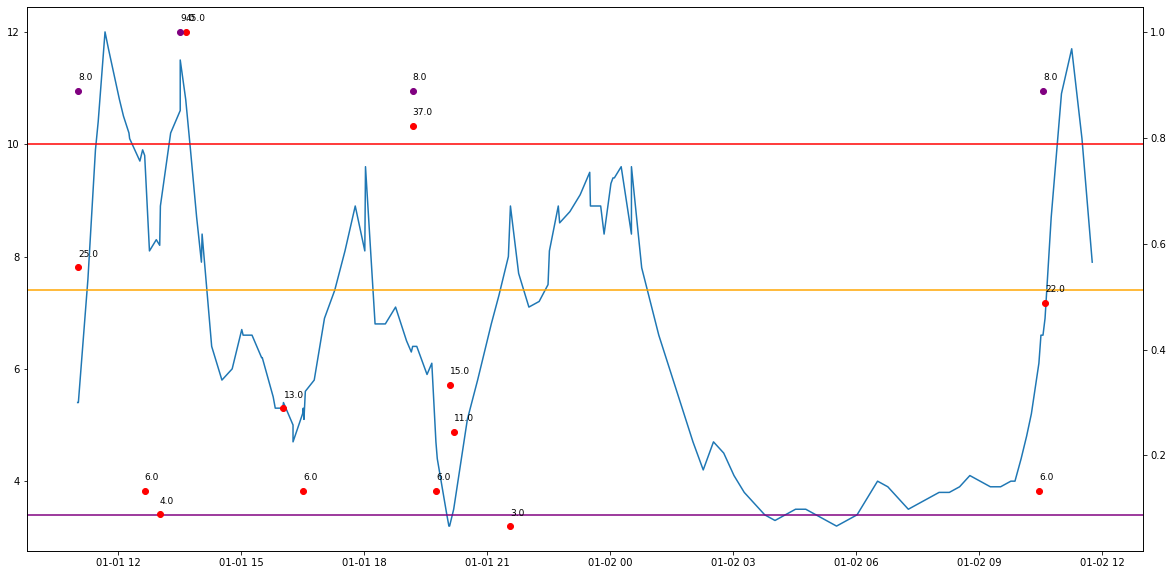

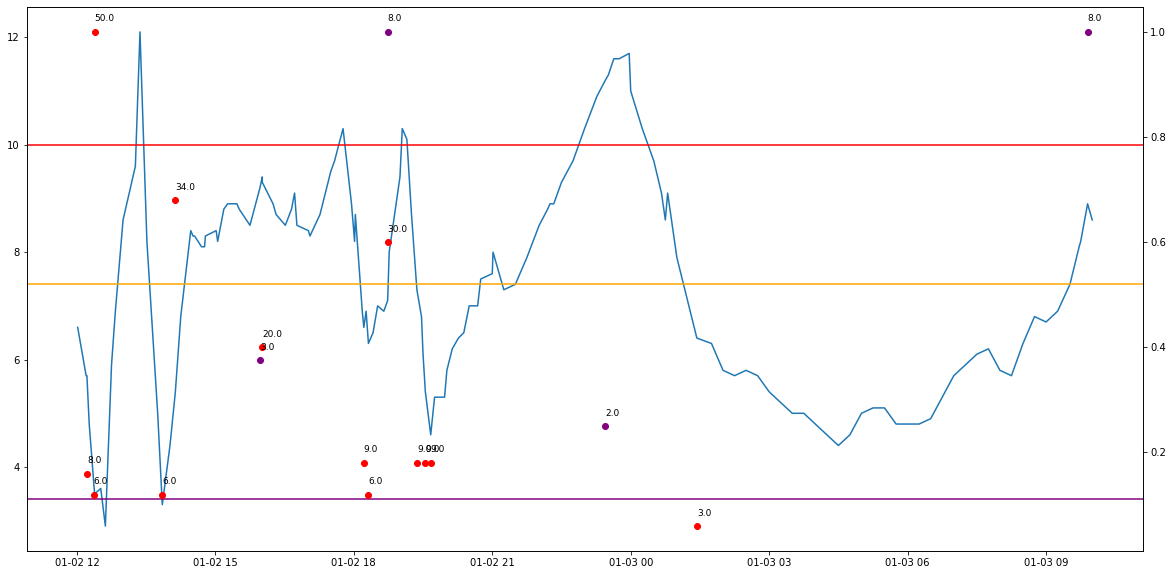

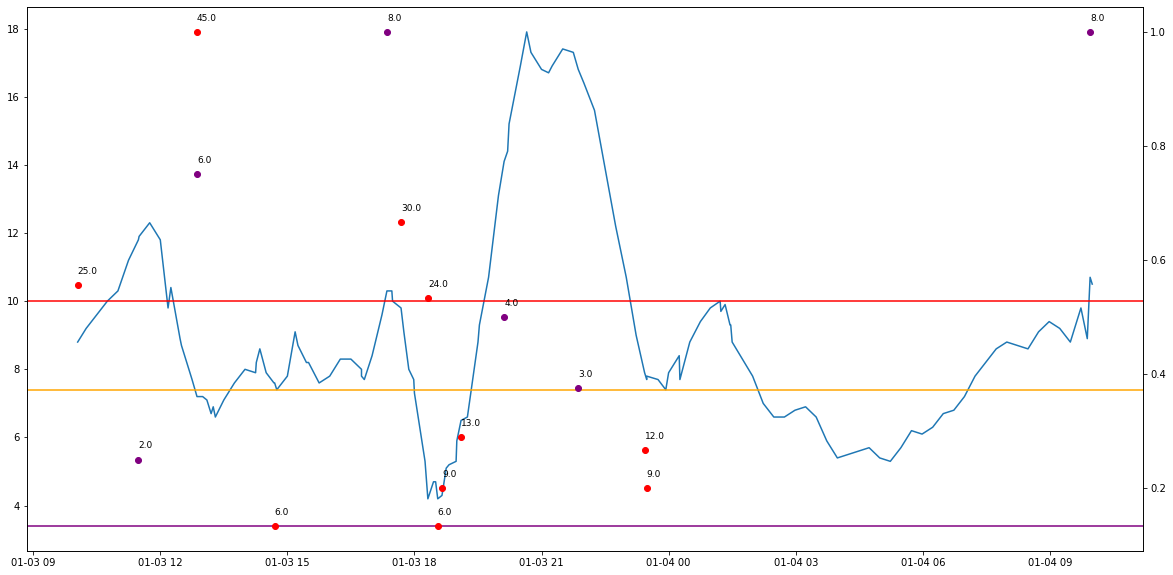

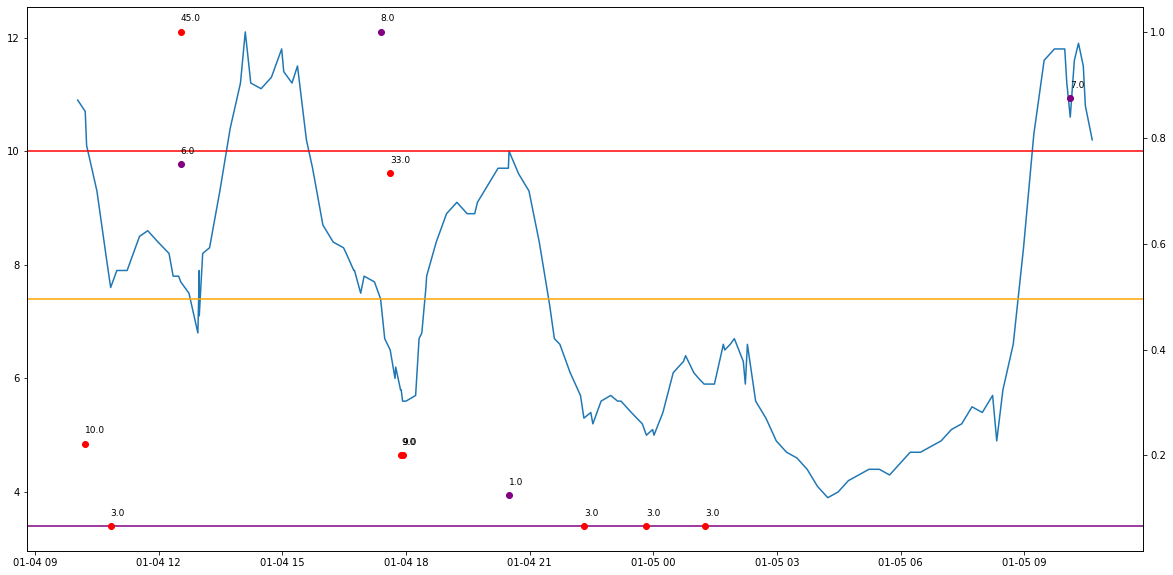

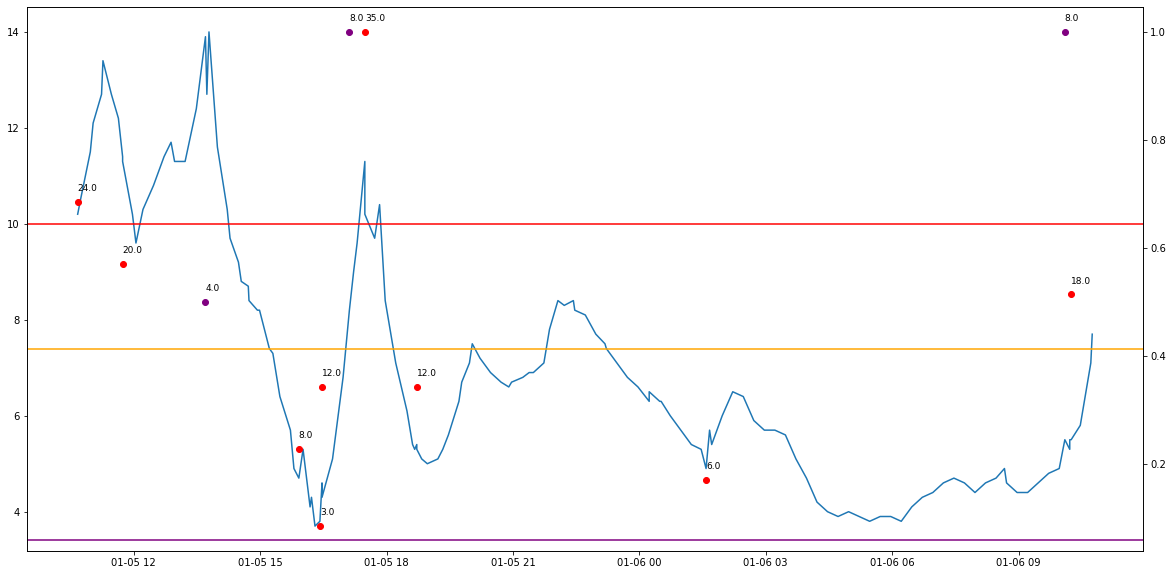

In [97]:
get_daily_charts(df, 30, 5)